<a href="https://colab.research.google.com/github/arzss-code/jobsheet-machine-learning/blob/main/Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tugas Akhir Materi Feature Extraction and Selection

Silakan pergunakan pengetahuan yang Anda dapat pada sesi kali ini terhadap dataset berikut:
1. https://www.kaggle.com/datasets/yasserh/wine-quality-dataset
2. https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv

Lakukan eksplorasi data dan feature selection pada data di atas.

# WineQT.csv

⏳ Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None

🔍 Missing Values:
 fixed acidity           0


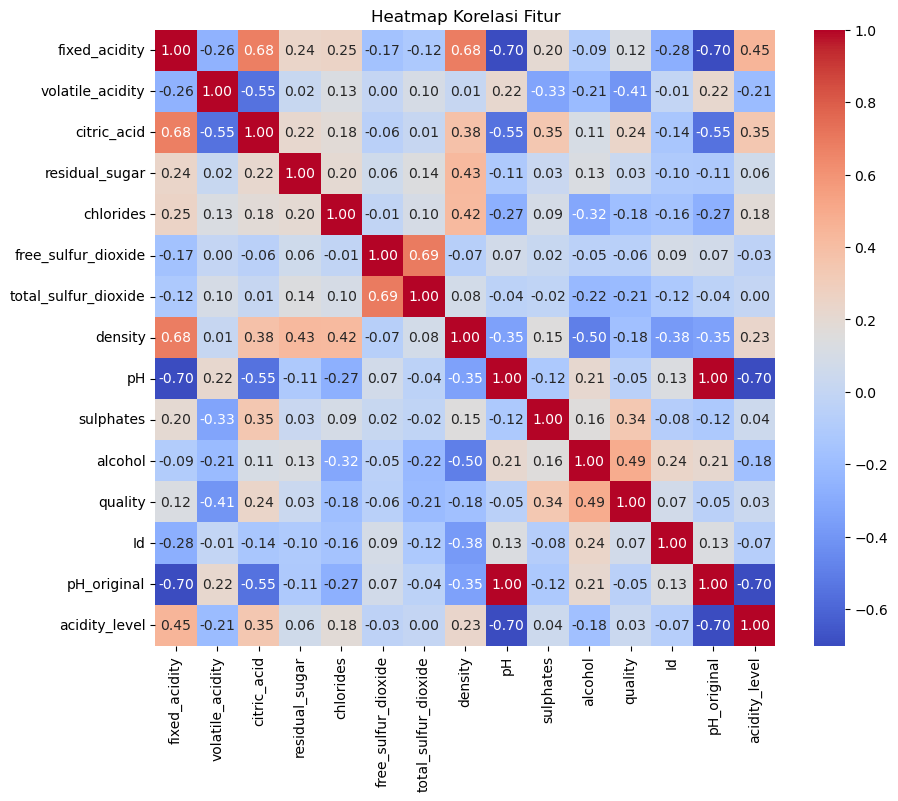


🔥 Fitur Penting Berdasarkan Korelasi > 0.3:
 ['quality', 'alcohol', 'sulphates', 'volatile_acidity']
Fitur yang dipilih menggunakan SelectKBest: ['volatile_acidity', 'citric_acid', 'total_sulfur_dioxide', 'sulphates', 'alcohol']

--- RFECV ---
Optimal number of features : 3
Ranking of features: [ 3  1  2  9  5  7  6  4 11  1  1  8 10 12]
Selected features (rank 1): ['volatile_acidity', 'sulphates', 'alcohol']


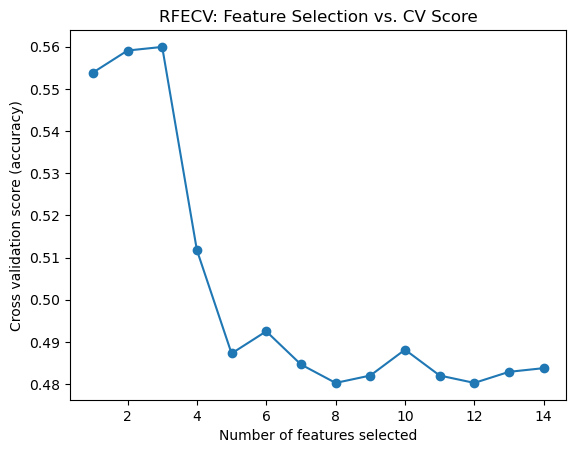

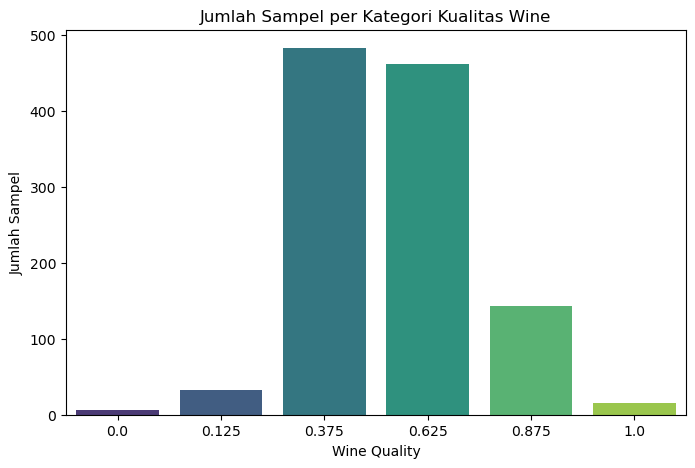

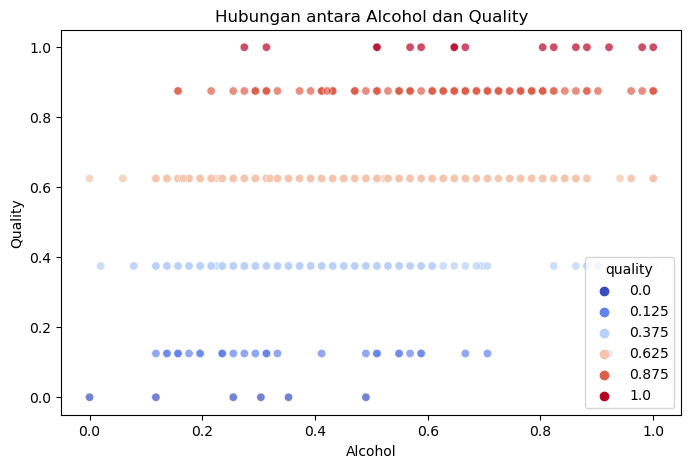

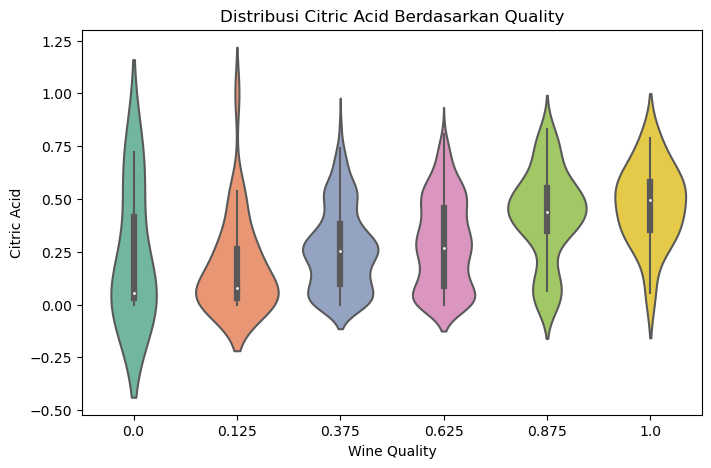

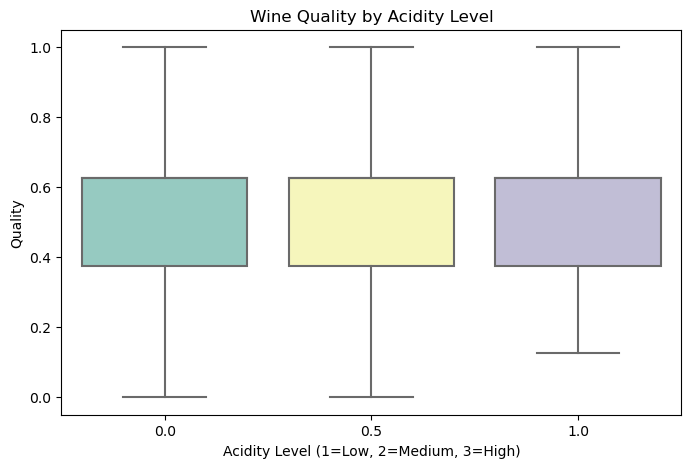


✅ Data Exploration and Feature Selection Completed


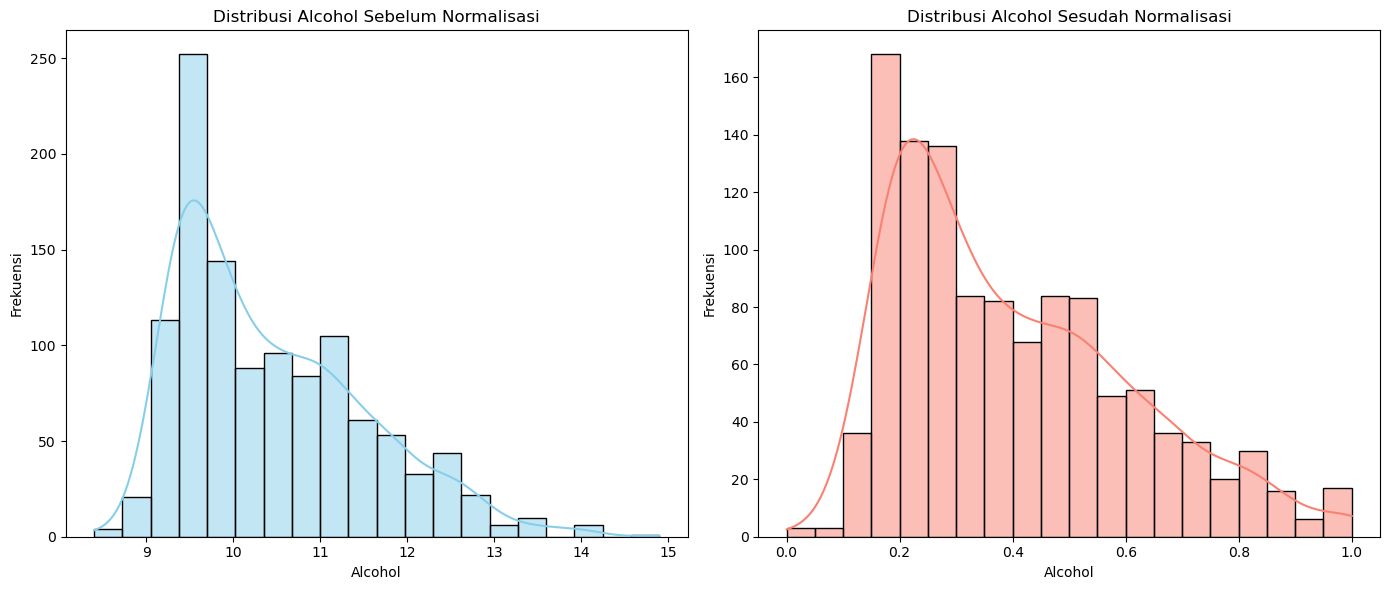

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# 1. Data Cleaning & Preprocessing
file_path = 'WineQT.csv'
df = pd.read_csv(file_path)

print("⏳ Initial Dataset Info:")
print(df.info())

# Mengatasi missing values
print("\n🔍 Missing Values:\n", df.isnull().sum())
df.dropna(inplace=True)

# Mengatasi duplikasi data
print("\n📑 Duplicate Rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# Mengganti spasi pada nama kolom dengan underscore
df.columns = df.columns.str.replace(' ', '_')
print("\n🧮 Updated Column Names:\n", df.columns)

# Memeriksa tipe data
print("\n🔍 Data Types:\n", df.dtypes)

# Simpan target variabel asli (sebagai integer) untuk keperluan klasifikasi
target = 'quality'
y_class = df[target].copy().astype(int)

# 2. Handling Outliers with Capping
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outlier_summary = []
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    upper_limit = Q3[column] + 1.5 * IQR[column]
    lower_limit = Q1[column] - 1.5 * IQR[column]

    num_outliers_before = ((df[column] > upper_limit) | (df[column] < lower_limit)).sum()

    df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
    df[column] = np.where(df[column] < lower_limit, lower_limit, df[column])

    num_outliers_after = ((df[column] > upper_limit) | (df[column] < lower_limit)).sum()

    outlier_summary.append([column, num_outliers_before, num_outliers_after])

outlier_df = pd.DataFrame(outlier_summary, columns=['Feature', 'Outliers Before', 'Outliers After'])
print("\n🚨 Outliers Capping Summary:\n", outlier_df.to_string(index=False))

# 3. Feature Engineering - Create acidity_level BEFORE scaling
# Save a copy of the original pH
df['pH_original'] = df['pH'].copy()

# Calculate acidity_level using original pH values
def acidity_level(pH):
    if pH < 3.0:
        return 'High'
    elif pH <= 3.5:
        return 'Medium'
    else:
        return 'Low'

df['acidity_level'] = df['pH_original'].apply(acidity_level)
# Convert to numeric values for correlation analysis
df['acidity_level'] = df['acidity_level'].map({'Low': 1, 'Medium': 2, 'High': 3})

print("\n🛠️ Feature Engineering Completed")

# 4. Basic Data Wrangling (Scaling)
# Scale all numerical features AFTER feature engineering
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
print("\n✅ Basic Data Wrangling Completed")

# 5. Feature Selection with Correlation & SelectKBest
# Calculate the correlation matrix AFTER all features are created and scaled
corr_matrix = df.corr()

# Heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Fitur')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Memilih fitur dengan korelasi > 0.3 terhadap target 'quality'
correlation_threshold = 0.3
correlations = corr_matrix[target].sort_values(ascending=False)
relevant_features = correlations[correlations.abs() > correlation_threshold].index.tolist()
print("\n🔥 Fitur Penting Berdasarkan Korelasi > 0.3:\n", relevant_features)

# Univariate Feature Selection dengan SelectKBest (menggunakan f_regression)
X = df.drop(columns=target)
y = df[target]  # y di sini adalah target yang sudah diskalakan, cukup untuk analisis regresi
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Fitur yang dipilih menggunakan SelectKBest:", list(selected_features))

# --- RFECV untuk Klasifikasi ---
# Menggunakan target asli (y_class) agar bersifat diskrit (multiclass) untuk SVC
svc = SVC(kernel="linear")
min_features_to_select = 1
X_numeric = df.select_dtypes(include=[np.number]).drop(columns=[target])
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_numeric, y_class)

print("\n--- RFECV ---")
print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features:", rfecv.ranking_)
print("Selected features (rank 1):", list(X_numeric.columns[rfecv.get_support()]))

# Plot RFECV: Jumlah fitur vs. skor CV menggunakan cv_results_
scores = rfecv.cv_results_["mean_test_score"]
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(scores) + min_features_to_select),
    scores,
    marker='o'
)
plt.title("RFECV: Feature Selection vs. CV Score")
plt.show()

# 6. Data Visualization
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Jumlah Sampel per Kategori Kualitas Wine')
plt.xlabel('Wine Quality')
plt.ylabel('Jumlah Sampel')
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='alcohol', y='quality', data=df, hue='quality', palette='coolwarm', alpha=0.7)
plt.title('Hubungan antara Alcohol dan Quality')
plt.xlabel('Alcohol')
plt.ylabel('Quality')
plt.show()

plt.figure(figsize=(8, 5))
sns.violinplot(x='quality', y='citric_acid', data=df, palette='Set2')
plt.title('Distribusi Citric Acid Berdasarkan Quality')
plt.xlabel('Wine Quality')
plt.ylabel('Citric Acid')
plt.show()

# Add visualization for acidity_level
plt.figure(figsize=(8, 5))
sns.boxplot(x='acidity_level', y='quality', data=df, palette='Set3')
plt.title('Wine Quality by Acidity Level')
plt.xlabel('Acidity Level (1=Low, 2=Medium, 3=High)')
plt.ylabel('Quality')
plt.show()

print("\n✅ Data Exploration and Feature Selection Completed")

# 7. Perbandingan Distribusi fitur sebelum dan sesudah normalisasi (contoh: alcohol)
df_original = pd.read_csv(file_path)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df_original['alcohol'], bins=20, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Distribusi Alcohol Sebelum Normalisasi')
ax[0].set_xlabel('Alcohol')
ax[0].set_ylabel('Frekuensi')

sns.histplot(df['alcohol'], bins=20, kde=True, color='salmon', ax=ax[1])
ax[1].set_title('Distribusi Alcohol Sesudah Normalisasi')
ax[1].set_xlabel('Alcohol')
ax[1].set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

# train.csv

⏳ Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null

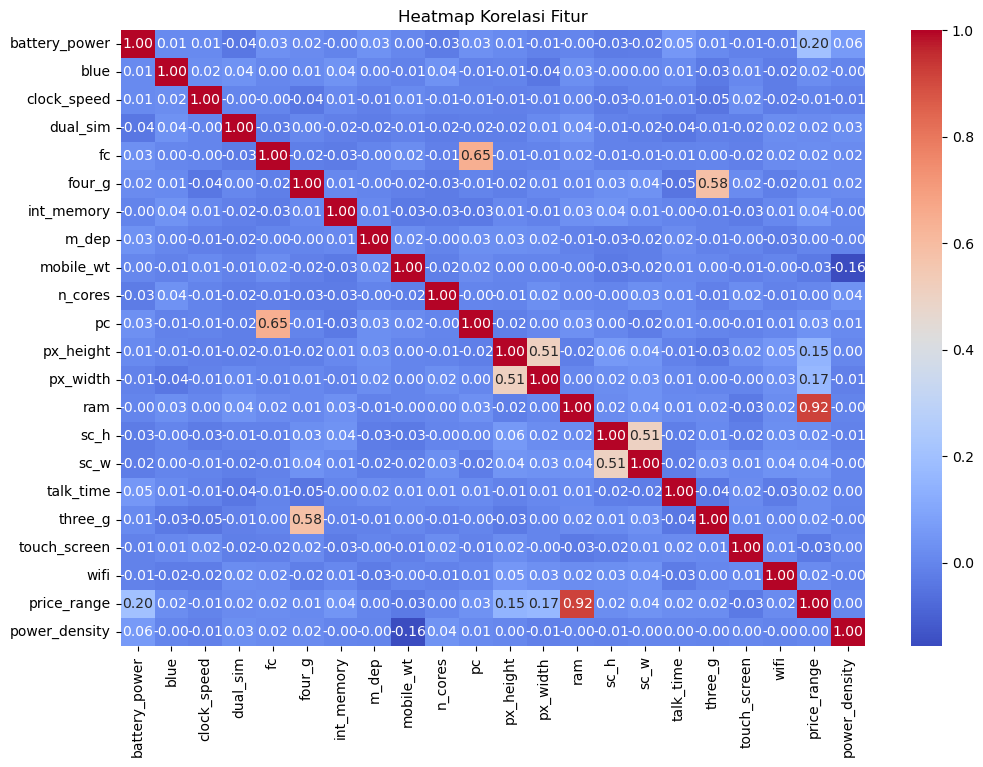


🔥 Fitur Penting Berdasarkan Korelasi > 0.3:
 ['price_range', 'ram']

--- SelectKBest (chi²) ---
Score list: [ 15.85060488   0.72323232   0.38619711   0.63101079   0.65341174
   1.52157239   1.54546984   1.03495817   1.86173187   1.66881734
   0.45930268   8.93155488  10.90640095 282.97127081   1.15675377
   0.91557328   0.89856842   0.32764281   1.92842942   0.42209073
   0.82325633]
Selected features: ['battery_power', 'px_height', 'px_width', 'ram', 'touch_screen']

--- RFECV ---
Optimal number of features : 5
Ranking of features: [ 1 17  5 11  9 12  4  7  1  6 16  1  1  1  3  8 10 13 15 14  2]
Selected features (rank 1): ['battery_power', 'mobile_wt', 'px_height', 'px_width', 'ram']


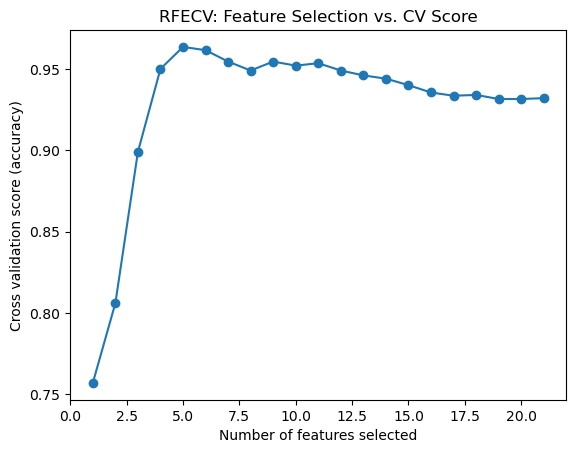

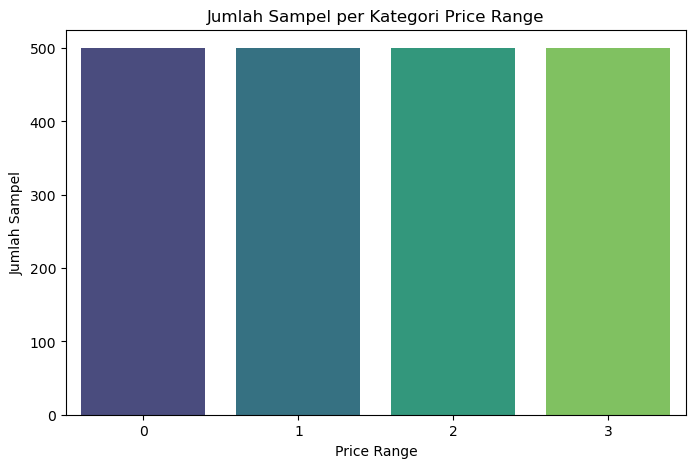

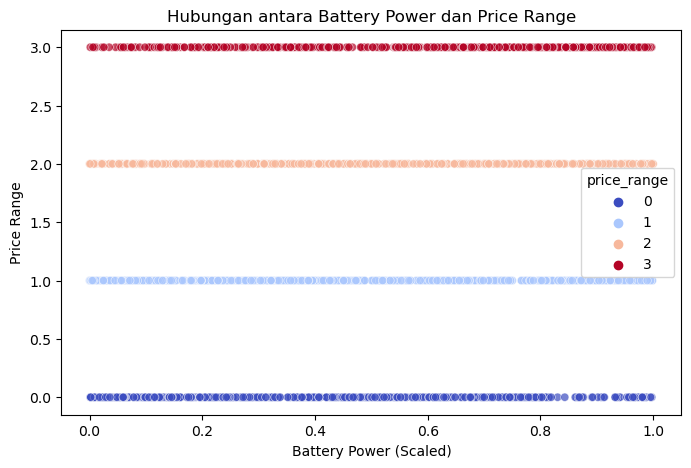

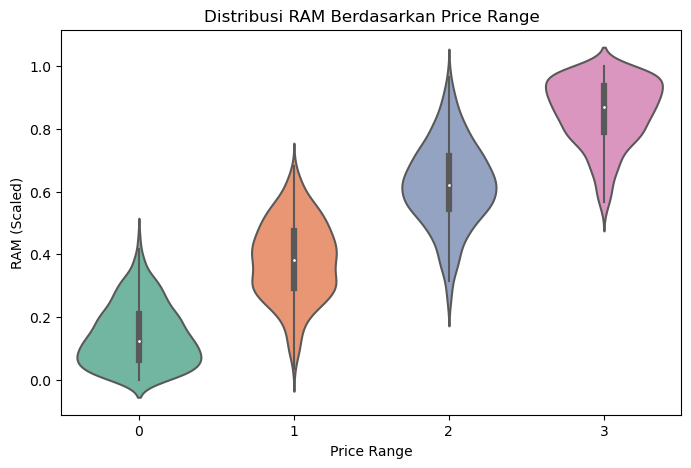

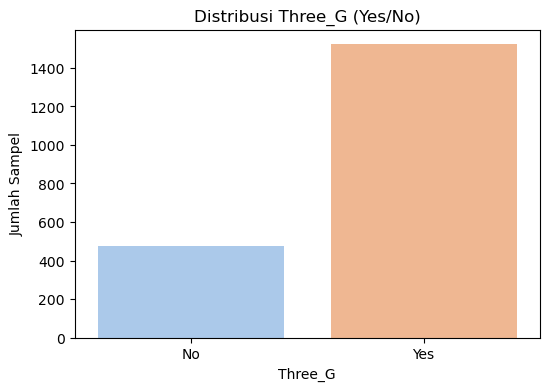


✅ Data Exploration and Feature Selection Completed


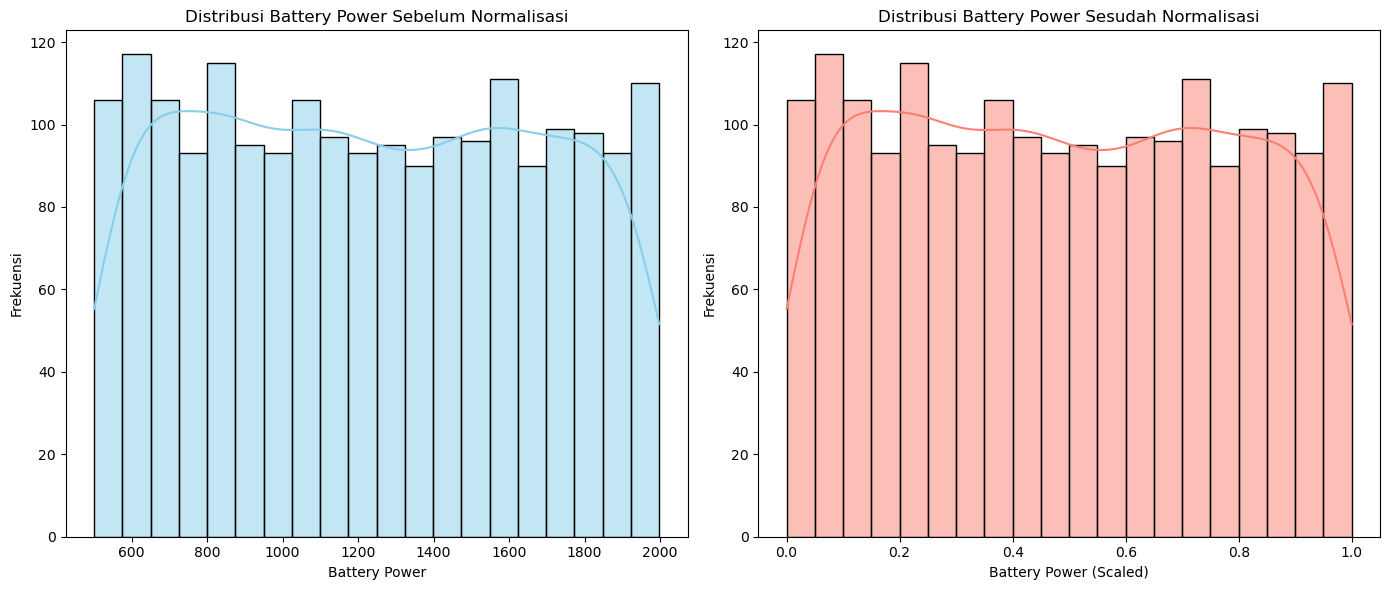

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# 1. Data Cleaning & Preprocessing
# Load dataset
file_path = 'train.csv'
df = pd.read_csv(file_path)

print("⏳ Initial Dataset Info:")
print(df.info())

# Cek missing values
print("\n🔍 Missing Values:\n", df.isnull().sum())
df.dropna(inplace=True)

# Cek duplikasi data
print("\n📑 Duplicate Rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# Ganti spasi pada nama kolom dengan underscore (jika ada)
df.columns = df.columns.str.replace(' ', '_')
print("\n🧮 Updated Column Names:\n", df.columns)

# Tampilkan tipe data
print("\n🔍 Data Types:\n", df.dtypes)

# Simpan target variabel secara terpisah dan pastikan tipenya integer
target = 'price_range'
y = df[target].copy().astype(int)

# 2. Handling Outliers with Capping (hanya untuk fitur kontinu)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outlier_summary = []
# Lakukan outlier capping hanya untuk kolom dengan lebih dari 2 nilai unik (bukan fitur biner)
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    if df[column].nunique() <= 2:
        # Lewati fitur biner
        outlier_summary.append([column, 0, 0])
        continue
    upper_limit = Q3[column] + 1.5 * IQR[column]
    lower_limit = Q1[column] - 1.5 * IQR[column]

    num_outliers_before = ((df[column] > upper_limit) | (df[column] < lower_limit)).sum()

    df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
    df[column] = np.where(df[column] < lower_limit, lower_limit, df[column])

    num_outliers_after = ((df[column] > upper_limit) | (df[column] < lower_limit)).sum()

    outlier_summary.append([column, num_outliers_before, num_outliers_after])

outlier_df = pd.DataFrame(outlier_summary, columns=['Feature', 'Outliers Before', 'Outliers After'])
print("\n🚨 Outliers Capping Summary:\n", outlier_df.to_string(index=False))

# 3. Konversi Fitur Biner ke Label Kategori (Yes/No)
# Fitur biner: hanya memiliki nilai 0 dan 1, jadi dibuat versi kategorinya untuk keperluan visualisasi
binary_columns = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
for col in binary_columns:
    df[col + '_cat'] = df[col].map({0: 'No', 1: 'Yes'})

# 4. Basic Data Wrangling (Scaling)
# Skalakan hanya fitur (selain target) agar nilai berada di rentang [0, 1]
features = df.drop(columns=[target])
numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
features[numeric_cols] = scaler.fit_transform(features[numeric_cols])

# Gabungkan kembali fitur yang sudah diskalakan dengan target asli
df = features.copy()
df[target] = y

print("\n✅ Basic Data Wrangling Completed")

# 5. Feature Engineering
# Contoh: Membuat fitur baru 'power_density' sebagai rasio battery_power terhadap mobile_wt
epsilon = 1e-10  # untuk menghindari pembagian dengan nol
df['power_density'] = df['battery_power'] / (df['mobile_wt'] + epsilon)
# Karena fitur baru ini masuk ke kategori kontinu, skalakan kembali nilainya
df[['power_density']] = scaler.fit_transform(df[['power_density']])
print("\n🛠️ Feature Engineering Completed")

# 6. Feature Selection

# --- 6a. Analisis Korelasi ---
# Hitung matriks korelasi dari kolom numerik saja
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Tampilkan heatmap korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Fitur')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Pilih fitur dengan korelasi > 0.3 terhadap target 'price_range'
correlation_threshold = 0.3
correlations = corr_matrix[target].sort_values(ascending=False)
relevant_features = correlations[correlations.abs() > correlation_threshold].index.tolist()
print("\n🔥 Fitur Penting Berdasarkan Korelasi > 0.3:\n", relevant_features)

# --- 6b. Univariate Feature Selection dengan SelectKBest (chi²) ---
# Karena fitur sudah diskalakan (nilai antara 0 dan 1) dan target merupakan label diskrit,
# SelectKBest dengan chi² dapat digunakan.
X_numeric = df.select_dtypes(include=[np.number]).drop(columns=[target])
select_feature = SelectKBest(score_func=chi2, k=5).fit(X_numeric, y)
print("\n--- SelectKBest (chi²) ---")
print("Score list:", select_feature.scores_)
print("Selected features:", list(X_numeric.columns[select_feature.get_support()]))

# --- 6c. Recursive Feature Elimination dengan Cross Validation (RFECV) ---
# Menggunakan SVC dengan kernel linear sebagai estimator.
svc = SVC(kernel="linear")
min_features_to_select = 1  # jumlah minimum fitur yang dipertimbangkan

rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_numeric, y)

print("\n--- RFECV ---")
print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features:", rfecv.ranking_)
print("Selected features (rank 1):", list(X_numeric.columns[rfecv.get_support()]))

# Plot RFECV: Jumlah fitur vs. skor CV menggunakan cv_results_
scores = rfecv.cv_results_["mean_test_score"]
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(scores) + min_features_to_select),
    scores,
    marker='o'
)
plt.title("RFECV: Feature Selection vs. CV Score")
plt.show()


# 7. Data Visualization

# a. Countplot untuk target 'price_range'
plt.figure(figsize=(8, 5))
sns.countplot(x=target, data=df, palette='viridis')
plt.title('Jumlah Sampel per Kategori Price Range')
plt.xlabel('Price Range')
plt.ylabel('Jumlah Sampel')
plt.show()

# b. Scatter plot: Battery Power vs Price Range
plt.figure(figsize=(8, 5))
sns.scatterplot(x='battery_power', y=target, data=df, hue=target, palette='coolwarm', alpha=0.7)
plt.title('Hubungan antara Battery Power dan Price Range')
plt.xlabel('Battery Power (Scaled)')
plt.ylabel('Price Range')
plt.show()

# c. Violin plot: Distribusi RAM Berdasarkan Price Range
plt.figure(figsize=(8, 5))
sns.violinplot(x=target, y='ram', data=df, palette='Set2')
plt.title('Distribusi RAM Berdasarkan Price Range')
plt.xlabel('Price Range')
plt.ylabel('RAM (Scaled)')
plt.show()

# d. Bar plot untuk fitur biner, misalnya fitur three_g (menggunakan versi kategorinya)
plt.figure(figsize=(6, 4))
sns.countplot(x='three_g_cat', data=df, palette='pastel')
plt.title('Distribusi Three_G (Yes/No)')
plt.xlabel('Three_G')
plt.ylabel('Jumlah Sampel')
plt.show()

print("\n✅ Data Exploration and Feature Selection Completed")

# 8. Perbandingan Distribusi fitur sebelum dan sesudah normalisasi (contoh: battery_power)
df_original = pd.read_csv(file_path)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df_original['battery_power'], bins=20, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Distribusi Battery Power Sebelum Normalisasi')
ax[0].set_xlabel('Battery Power')
ax[0].set_ylabel('Frekuensi')

sns.histplot(df['battery_power'], bins=20, kde=True, color='salmon', ax=ax[1])
ax[1].set_title('Distribusi Battery Power Sesudah Normalisasi')
ax[1].set_xlabel('Battery Power (Scaled)')
ax[1].set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()